# ISIC 2018

* (c) Nagender Aneja, naneja@gmail.com; naneja@ieee.org; nagender.aneja@ubd.edu.bn
* http://researchid.co/naneja

In [1]:
arch = 'resnet152'

inp_size = 224

epochs = 5

LR = 0.00001
BS = 200

manual_seed = 100

classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

ckpt = f'./data/model/{arch}.pth'

gpu = 'cuda:0'

In [2]:
#!conda update pytorch torchvision --yes

In [3]:
import os
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import copy
import itertools
from collections import OrderedDict
import json
from datetime import datetime

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from skimage import io, transform
from IPython.display import display

import torch
import torchvision
from torch import optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler


from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader


from torchvision import transforms

import warnings
warnings.filterwarnings("ignore")

print(torch.__version__)

random.seed(manual_seed)
np.random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.cuda.manual_seed_all(manual_seed)
torch.backends.cudnn.deterministic = True

device = gpu if torch.cuda.is_available() else 'cpu'
print(device)

torch.cuda.empty_cache()

1.3.1
cuda:0


In [4]:
!nvidia-smi

Thu Dec  5 20:35:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P2    39W /  N/A |   1206MiB /  8085MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Preprocessing

In [5]:
# class to idx and idx to class
nclasses = len(classes)

class2idx = {}
idx2class = {}
for idx, cl in enumerate(classes):
    class2idx[cl] = idx
    idx2class[idx] = cl

print(class2idx)
print(idx2class)

{'MEL': 0, 'NV': 1, 'BCC': 2, 'AKIEC': 3, 'BKL': 4, 'DF': 5, 'VASC': 6}
{0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AKIEC', 4: 'BKL', 5: 'DF', 6: 'VASC'}


10015


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0


[1113, 6705, 514, 327, 1099, 115, 142]


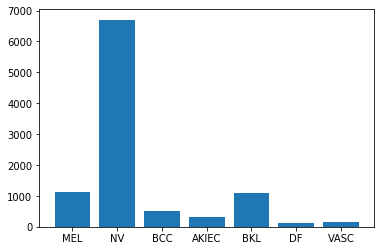

In [6]:
# read Labels file and plot

df = pd.read_csv('data/train_labels.csv')
print(len(df))

display(df.head(2))
                    
count = []
for cl in classes:
    val = int(df[cl].sum())
    count.append(val)

print(count)

plt.bar(classes, count);

In [7]:
# return idx for label

def get_cat(img):
    df_img = df[df['image'] == img]
    df_img.reset_index(drop=True, inplace=True)
    for cat in classes:
        v = int(df_img.loc[0, cat])
        if v == 1:  # where in the column is 1 is the cat
            lbl = class2idx[cat]
    return lbl

In [8]:
# create a list of tuples (image, label)

if os.path.exists('./data/Xy.pkl'):
    with open('./data/Xy.pkl', 'rb') as f:
        Xy = pickle.load(f)
else:
    X = list(df['image'])
    y = [get_cat(img) for img in X]
    Xy = list()
    for img, lbl in zip(X, y):
        img_path = f'./data/train/{img}.jpg'
        tup = (img_path, lbl)
        Xy.append(tup)
        with open('./data/Xy.pkl', 'wb') as f:
            pickle.dump(Xy, f)

In [9]:
# Create weights for each class - weighted sampling
print(count)
weight_per_class = [0.] * nclasses

N = float(sum(count))
for i in range(nclasses):                                                   
    weight_per_class[i] = N/float(count[i])  
print(weight_per_class)

weights = [0] * len(Xy)                                              
for idx, val in enumerate(Xy):                                          
    weights[idx] = weight_per_class[val[1]]  
    
print(len(weights))

[1113, 6705, 514, 327, 1099, 115, 142]
[8.998203054806828, 1.493661446681581, 19.48443579766537, 30.62691131498471, 9.112829845313922, 87.08695652173913, 70.52816901408451]
10015


In [10]:
# Transforms

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

tt = [transforms.Resize(360)]

tt.extend([transforms.CenterCrop(inp_size)])

tt.extend([transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip()])
tt.extend([transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)])

tv = [transforms.Resize(360), transforms.CenterCrop(inp_size)]

both = [transforms.ToTensor(), transforms.Normalize(mean, std)]

tt.extend(both)
tv.extend(both)

train_transform = transforms.Compose(tt)
valid_transform = transforms.Compose(tv)

In [11]:
# Dataset to be used for training

class MyDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.paths[idx]
        image = io.imread(img_name)
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
        
        im = os.path.split(img_name)[-1][:-4]

        label = get_cat(im)
        
        return image, label, img_name

In [12]:
filenames = [X[0] for X in Xy]
dataset = MyDataset(filenames, transform=train_transform)

In [13]:
weights = torch.DoubleTensor(weights)                                       
sampler = WeightedRandomSampler(weights, len(weights))                     
                                                                                
loader = torch.utils.data.DataLoader(dataset, batch_size=BS, shuffle=False, \
                                           sampler=sampler, num_workers=2, pin_memory=True)     

In [14]:
# Check if weighted sampling working OK
lbls = []
for idx, (imgs, labels, names) in enumerate(loader):
    lbls.extend(labels.tolist())
    counter = Counter(lbls)
    counter = sorted(counter.items(),key = lambda i: i[0])
    print(idx+1, imgs.shape, labels.shape, len(names))
    print('   ', counter)
    break

1 torch.Size([200, 3, 224, 224]) torch.Size([200]) 200
    [(0, 29), (1, 39), (2, 24), (3, 23), (4, 30), (5, 24), (6, 31)]


# Model

In [15]:
get_model = getattr(torchvision.models, arch)
model = get_model(pretrained=True)

In [16]:
model.fc = nn.Linear(model.fc.in_features, nclasses)
model.fc

Linear(in_features=2048, out_features=7, bias=True)

In [17]:
for idx, child in enumerate(model.children()):
    print('Layer ', idx, ':\n', child, end='\n\n')

Layer  0 :
 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Layer  1 :
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Layer  2 :
 ReLU(inplace=True)

Layer  3 :
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

Layer  4 :
 Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

In [18]:
for param in model.parameters():
    param.requires_grad = True

In [19]:
# Check Gradient status for all layers

for idx, child in enumerate(model.children()):
    for param in child.parameters():
        print(idx, '->', param.requires_grad)
        break

0 -> True
1 -> True
4 -> True
5 -> True
6 -> True
7 -> True
9 -> True


In [20]:
# Freeze initial layers

for idx, child in enumerate(model.children()):
    if idx < 7:
        for param in child.parameters():
            param.requires_grad = False

In [21]:
# Check Gradient status of all layers after freezing initial layers

for idx, child in enumerate(model.children()):
    for param in child.parameters():
        print(idx, '->', param.requires_grad)
        break

0 -> False
1 -> False
4 -> False
5 -> False
6 -> False
7 -> True
9 -> True


# Sample

In [22]:
images, labels, names = next(iter(loader))
names = list(names)

In [23]:
mean, std

((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

In [24]:
inv_normalize = transforms.Normalize(
    mean=[-0.485*0.229, -0.456*0.224, -0.406*0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
#tdn = transforms.Denormalize(mean, std)

torch.Size([3, 454, 1810])


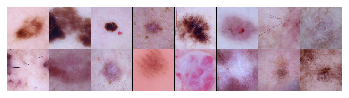

In [25]:
def imshow(img):
    #img = img.numpy()
    print(img.shape)
    #img = (img * std) + mean
    
    #img = inv_normalize(img)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')

#imshow(images[0])

imgs = images[:16]
lbls = labels[:16]
nms = names[:16]

imshow(torchvision.utils.make_grid(imgs, nrow=8, normalize=True))

l = list(lbls.numpy())

#print(l[:len(l)//2])
#print(l[len(l)//2:])
#print(nms)

# Train

In [26]:


model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.fc.parameters(), lr=LR, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01)

In [27]:
# Save the model when error is less

def train(model, epoch_loss):
        
    model.train()
    
    best_model_weights = copy.deepcopy(model.state_dict())
    running_loss = 0.0
    
    for idx, (inputs, labels, names) in enumerate(loader):
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
        print(idx, end='\r')
        
    running_loss = running_loss / len(dataset)
    
    if running_loss < epoch_loss:
        # Save the checkpoint
        best_model_weights = copy.deepcopy(model.state_dict())
        
        model.load_state_dict(best_model_weights)
        checkpoint_dict = {
            'arch': arch,
            'classes': classes,
            'class_to_idx': class2idx,
            'loss': running_loss,
            'state_dict': model.state_dict()
        }
        torch.save(checkpoint_dict, ckpt)
        print('   model saved')
    return model, running_loss

In [28]:
f = f'./data/out/log-{arch}.json'

if os.path.exists(ckpt):
    checkpoint = torch.load(ckpt, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    epoch_loss = checkpoint['loss']
    print('Model Loaded')
    
    with open(f, 'r') as fp:
        log_json = json.load(fp)
    losses = log_json['losses']
    times = log_json['times']
else:
    losses = []
    times = []
    epoch_loss = np.inf
    log_json = {'losses': losses, 'times': times}
    
if device == 'cpu':
        epochs = 0
        
for epoch in range(epochs):
    
    start=datetime.now()
    model, epoch_loss = train(model, epoch_loss)
    losses.append(epoch_loss)
    epoch_loss = min(losses)
    time = datetime.now() - start
    time = time.seconds
    
    times.append(time)
    print(epoch+1, epoch_loss, time)

if epochs > 0:
    log_json['losses'] = losses
    log_json['times'] = times
    print(log_json)
    with open(f, 'w') as fp:
        json.dump(log_json, fp, indent=4)

Model Loaded
1 0.3421649646889967 70
2 0.3421649646889967 72
3 0.3421649646889967 72
4 0.3421649646889967 72
5 0.3421649646889967 72
{'losses': [1.049399031053706, 0.7722337210529516, 0.707298272529722, 0.732166660766392, 0.6723394178475253, 0.6378843268929156, 0.6131439311648391, 0.5847029639849708, 0.564272960810678, 0.5822251801840734, 0.5547224262983157, 0.5653747413614304, 0.5513991093076115, 0.5257517467483067, 0.523558027971642, 0.5273165970787785, 0.5143218853148709, 0.5184353342130074, 0.5183926139452787, 0.48942165599723964, 0.4794463366939613, 0.4843619922310843, 0.47892307437662474, 0.5048362795287707, 0.4874997622837023, 0.4772784002590227, 0.46079079181149313, 0.4617376592506841, 0.4397310531264356, 0.46178330844096166, 0.439998576537526, 0.4513101356212818, 0.44739642714001926, 0.4258960346192404, 0.4278886284878179, 0.43998171346698234, 0.4319397865743918, 0.43411081358306836, 0.43608811210526627, 0.4173753964740279, 0.4062105029062575, 0.42126902475157085, 0.3749822902

In [29]:
if (len(losses) > 0):
    print(losses)
    print(times)

[1.049399031053706, 0.7722337210529516, 0.707298272529722, 0.732166660766392, 0.6723394178475253, 0.6378843268929156, 0.6131439311648391, 0.5847029639849708, 0.564272960810678, 0.5822251801840734, 0.5547224262983157, 0.5653747413614304, 0.5513991093076115, 0.5257517467483067, 0.523558027971642, 0.5273165970787785, 0.5143218853148709, 0.5184353342130074, 0.5183926139452787, 0.48942165599723964, 0.4794463366939613, 0.4843619922310843, 0.47892307437662474, 0.5048362795287707, 0.4874997622837023, 0.4772784002590227, 0.46079079181149313, 0.4617376592506841, 0.4397310531264356, 0.46178330844096166, 0.439998576537526, 0.4513101356212818, 0.44739642714001926, 0.4258960346192404, 0.4278886284878179, 0.43998171346698234, 0.4319397865743918, 0.43411081358306836, 0.43608811210526627, 0.4173753964740279, 0.4062105029062575, 0.42126902475157085, 0.3749822902786571, 0.38092039898223895, 0.36637341941944435, 0.37240645055823246, 0.36130938374335564, 0.35588916326783265, 0.3495268657305094, 0.358900086

In [30]:
def test(model, dataloader):
    y_obs, y_pred = [], []
    
    model.eval()
    
    for idx, (inputs, labels, names) in enumerate(dataloader):
        print(idx+1, end='\r')
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        ps = torch.exp(outputs)

        _, preds = torch.max(outputs, 1)

        y_obs.append(labels.data.tolist())
        y_pred.append(preds.tolist())
    
    y_obs = list(itertools.chain.from_iterable(y_obs)) # flat
    y_pred = list(itertools.chain.from_iterable(y_pred))

    stack = (y_obs, y_pred)
    
    return stack

In [31]:
# Train Accuracy

f = f'./data/out/{arch}.csv'
if os.path.exists(f):
    df = pd.read_csv(f)
    display(df.head(2))
else:
    stack = test(model, loader)
    header = 'y_obs,' + 'y_pred'
    np.savetxt(f, np.column_stack(stack), delimiter=",", fmt='%i,%i',\
               header=header, comments='')
    df = pd.read_csv(f)
    display(df.head(2))

,y_obs,y_pred
0,3,5
1,3,3


In [32]:
def conf_mat(df, nclasses, classes=None):
    shape = (nclasses, nclasses)
    mat = np.zeros(shape)
    for i in range(len(df['y_obs'])):
        obs = df.iloc[i, 0]
        pred = df.iloc[i, 1]
        mat[obs, pred] = mat[obs, pred] + 1

    idxo = ['obs-'+str(i) for i in range(nclasses)]
    idxp = ['pred-' + str(i) for i in range(nclasses)]
    if classes:
        idxo = classes
        idxp = classes
    df = pd.DataFrame(mat, index=idxo, dtype='int32', columns=idxp)
    return df

In [33]:
# Train 
conf_mat(df, nclasses, classes)

,MEL,NV,BCC,AKIEC,BKL,DF,VASC
MEL,1222,30,60,24,48,26,7
NV,500,687,73,2,39,57,21
BCC,98,2,1200,20,25,50,19
AKIEC,287,5,366,616,61,79,0
BKL,530,23,190,32,590,93,4
DF,104,19,110,9,29,1184,0
VASC,74,2,94,0,6,27,1271


In [34]:
# Dataset for submit since there are known labels

class MyDatasetSubmit(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.paths[idx]
        image = io.imread(img_name)
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
        
        im = os.path.split(img_name)[-1][:-4]
        
        return image, img_name

In [35]:
submit_paths = glob.glob('./data/test/*.jpg')

submit_ds = MyDatasetSubmit(submit_paths, valid_transform)

submit_loader = DataLoader(submit_ds, batch_size=BS, shuffle=False)

len(submit_ds), len(submit_loader)

(1512, 8)

In [36]:
# Logits for all classes for submission folder
def submit(model, dataloader):
    y_img, y_pred = [], []
    result = OrderedDict()
    
    model.eval()
    
    for idx, (inputs, names) in enumerate(dataloader):
        print(idx+1, end='\r')
        inputs = inputs.to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            ps = torch.exp(outputs)
        
            #ps = torch.sigmoid(ps)
            
            ps = ps.cpu().numpy()
            
            for ii in range(len(names)):
                nn = names[ii].split('/')[-1][:-4]
                pp = [str(p) for p in ps[ii]]
                result[nn] = pp
            
            y_img.append(list(names))
            y_pred.append(ps)
    
    return result

In [37]:
# Load or save Logits to json
f = f'./data/out/submit-{arch}-logits.json'
if os.path.exists(f):
    with open(f, 'r') as fp:
        result = json.load(fp)
else:
    result = submit(model, submit_loader)
    
    with open(f, 'w') as fp:
        json.dump(result, fp, indent=4)
print(len(result))

1512


In [38]:
# Convert Logits to probabilities by softmax

from sklearn.utils.extmath import softmax

csv = ','.join(classes)
csv = 'image,' + csv

vals = np.zeros((1512, 7))

print(vals.sum(axis=1))

i = 0

for k, v in result.items():
    val = [float(val) for val in v]
    val = np.array(val)    
    vals[i,:] = val
    i += 1
vals = softmax(vals)
print(vals.sum(axis=1))

for idx, k in enumerate(result.keys()):
    v = vals[idx, :]
    v = ','.join(map(str, v))
    r = k + ',' + v
    csv += '\n' + r

[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]


In [39]:
# Save Probs to upload the result
f = f'./data/out/submit-{arch}-softmax.csv'
with open(f, 'w') as fp:
    fp.write(csv)